In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels
from statsmodels.tsa import stattools

In [2]:
df=pd.read_csv('Helsinki.txt')

###### Cleaning Data

In [3]:
df.columns

Index([' STAID', ' SOUID', '    DATE', '   TG', ' Q_TG'], dtype='object')

In [4]:
df1=df.drop(' STAID',axis=1)

In [5]:
df1=df1.drop(' SOUID',axis=1)

In [6]:
df1[df1[' Q_TG']==9]

,DATE,TG,Q_TG
0,19911001,-9999,9
1,19911002,-9999,9
2,19911003,-9999,9
3,19911004,-9999,9
4,19911005,-9999,9
...,...,...,...
10109,20190605,-9999,9
10110,20190606,-9999,9
10111,20190607,-9999,9
10112,20190608,-9999,9


In [7]:
df1['   TG']=df1['   TG'].replace(-9999,df1['   TG'].mean())

In [8]:
df1=df1.drop(' Q_TG',axis=1)

In [9]:
df1.rename(columns={'    DATE':'Date','   TG':'TG'},inplace=True)

In [10]:
df1

,Date,TG
0,19911001,-47.194845
1,19911002,-47.194845
2,19911003,-47.194845
3,19911004,-47.194845
4,19911005,-47.194845
...,...,...
11014,20211126,-5.000000
11015,20211127,-50.000000
11016,20211128,-49.000000
11017,20211129,-36.000000


###### Date column in datetime + splitting the date

In [11]:
df1['Date']=pd.to_datetime(df1['Date'],format='%Y%m%d')

In [12]:
df1['year']=df1['Date'].dt.year

In [13]:
df1['month']=df1['Date'].dt.month

###### TG*0.1 to get Celsius

In [14]:
df1['TG']=df1['TG']*0.1

<AxesSubplot:xlabel='year'>

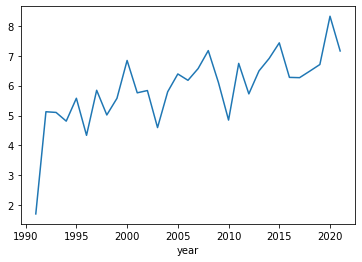

In [15]:
df1.groupby('year')['TG'].mean().plot()

###### Inserting Timesteps

In [16]:
df1['timestep'] = range(len(df1))

In [17]:
df1

,Date,TG,year,month,timestep
0,1991-10-01,-4.719485,1991,10,0
1,1991-10-02,-4.719485,1991,10,1
2,1991-10-03,-4.719485,1991,10,2
3,1991-10-04,-4.719485,1991,10,3
4,1991-10-05,-4.719485,1991,10,4
...,...,...,...,...,...
11014,2021-11-26,-0.500000,2021,11,11014
11015,2021-11-27,-5.000000,2021,11,11015
11016,2021-11-28,-4.900000,2021,11,11016
11017,2021-11-29,-3.600000,2021,11,11017


###### Creating monthly/Seasonal dummies

In [18]:
seasonal_dummies = pd.get_dummies(
    data=df1['month'],
    prefix='month',
    drop_first=True)

seasonal_dummies

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11014,0,0,0,0,0,0,0,0,0,1,0
11015,0,0,0,0,0,0,0,0,0,1,0
11016,0,0,0,0,0,0,0,0,0,1,0
11017,0,0,0,0,0,0,0,0,0,1,0


In [19]:
df1 = df1.join(seasonal_dummies)
df1

,Date,TG,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1991-10-01,-4.719485,1991,10,0,0,0,0,0,0,0,0,0,1,0,0
1,1991-10-02,-4.719485,1991,10,1,0,0,0,0,0,0,0,0,1,0,0
2,1991-10-03,-4.719485,1991,10,2,0,0,0,0,0,0,0,0,1,0,0
3,1991-10-04,-4.719485,1991,10,3,0,0,0,0,0,0,0,0,1,0,0
4,1991-10-05,-4.719485,1991,10,4,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11014,2021-11-26,-0.500000,2021,11,11014,0,0,0,0,0,0,0,0,0,1,0
11015,2021-11-27,-5.000000,2021,11,11015,0,0,0,0,0,0,0,0,0,1,0
11016,2021-11-28,-4.900000,2021,11,11016,0,0,0,0,0,0,0,0,0,1,0
11017,2021-11-29,-3.600000,2021,11,11017,0,0,0,0,0,0,0,0,0,1,0


In [20]:
df1.set_index('Date',inplace=True)

In [21]:
df1

,TG,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Date,,,,,,,,,,,,,,,
1991-10-01,-4.719485,1991,10,0,0,0,0,0,0,0,0,0,1,0,0
1991-10-02,-4.719485,1991,10,1,0,0,0,0,0,0,0,0,1,0,0
1991-10-03,-4.719485,1991,10,2,0,0,0,0,0,0,0,0,1,0,0
1991-10-04,-4.719485,1991,10,3,0,0,0,0,0,0,0,0,1,0,0
1991-10-05,-4.719485,1991,10,4,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26,-0.500000,2021,11,11014,0,0,0,0,0,0,0,0,0,1,0
2021-11-27,-5.000000,2021,11,11015,0,0,0,0,0,0,0,0,0,1,0
2021-11-28,-4.900000,2021,11,11016,0,0,0,0,0,0,0,0,0,1,0


###### Splitting the Data -> Train all Data except the last Year / Test Data from the last Year

In [22]:
df_train=df1[:-365]
df_test=df1[-365:]

###### Building the first model on the trend

In [23]:
X1 = df_train[['timestep']]
y1 = df_train['TG']

In [24]:
m_trend=LinearRegression ()

m_trend.fit(X1,y1)

LinearRegression()

In [25]:
df_train['trend']=m_trend.predict(X1)

<ipython-input-25-fb42edd3c28b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['trend']=m_trend.predict(X1)


In [26]:
df_train

,TG,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend
Date,,,,,,,,,,,,,,,,
1991-10-01,-4.719485,1991,10,0,0,0,0,0,0,0,0,0,1,0,0,4.645216
1991-10-02,-4.719485,1991,10,1,0,0,0,0,0,0,0,0,1,0,0,4.645471
1991-10-03,-4.719485,1991,10,2,0,0,0,0,0,0,0,0,1,0,0,4.645726
1991-10-04,-4.719485,1991,10,3,0,0,0,0,0,0,0,0,1,0,0,4.645982
1991-10-05,-4.719485,1991,10,4,0,0,0,0,0,0,0,0,1,0,0,4.646237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,6.400000,2020,11,10649,0,0,0,0,0,0,0,0,0,1,0,7.361776
2020-11-27,1.900000,2020,11,10650,0,0,0,0,0,0,0,0,0,1,0,7.362031
2020-11-28,2.300000,2020,11,10651,0,0,0,0,0,0,0,0,0,1,0,7.362286


<ipython-input-27-b1c0355cedd3>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_train.groupby('year')['TG','trend'].mean().plot()


<AxesSubplot:xlabel='year'>

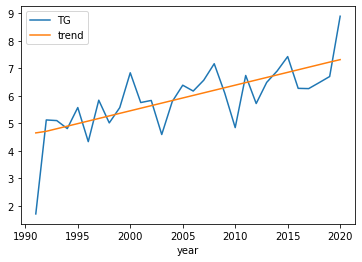

In [27]:
df_train.groupby('year')['TG','trend'].mean().plot()

###### Building a model on the seasonal trend

In [28]:
X_season = df_train.drop(['year','TG', 'month','trend'],axis=1) 
y_season = df_train['TG']

In [29]:
m_season = LinearRegression()
m_season.fit(X_season,y_season)
df_train['trend_season'] = m_season.predict(X_season)

<ipython-input-29-fe07e7fd6e1e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['trend_season'] = m_season.predict(X_season)


In [30]:
df_train

,TG,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend,trend_season
Date,,,,,,,,,,,,,,,,,
1991-10-01,-4.719485,1991,10,0,0,0,0,0,0,0,0,0,1,0,0,4.645216,6.017947
1991-10-02,-4.719485,1991,10,1,0,0,0,0,0,0,0,0,1,0,0,4.645471,6.018150
1991-10-03,-4.719485,1991,10,2,0,0,0,0,0,0,0,0,1,0,0,4.645726,6.018353
1991-10-04,-4.719485,1991,10,3,0,0,0,0,0,0,0,0,1,0,0,4.645982,6.018557
1991-10-05,-4.719485,1991,10,4,0,0,0,0,0,0,0,0,1,0,0,4.646237,6.018760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,6.400000,2020,11,10649,0,0,0,0,0,0,0,0,0,1,0,7.361776,4.054499
2020-11-27,1.900000,2020,11,10650,0,0,0,0,0,0,0,0,0,1,0,7.362031,4.054702
2020-11-28,2.300000,2020,11,10651,0,0,0,0,0,0,0,0,0,1,0,7.362286,4.054905


<ipython-input-31-4a337e3d7fce>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_train.groupby('year')['TG','trend_season'].mean().plot()


<AxesSubplot:xlabel='year'>

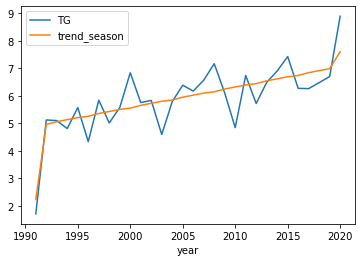

In [31]:
df_train.groupby('year')['TG','trend_season'].mean().plot()

###### Extract the remainder

In [32]:
df_train['remainder'] = df_train['TG'] - df_train['trend_season']

<ipython-input-32-e54e63d331b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['remainder'] = df_train['TG'] - df_train['trend_season']


<AxesSubplot:xlabel='year'>

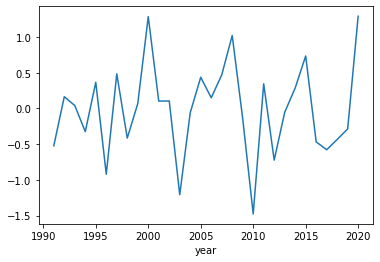

In [33]:
df_train.groupby('year')['remainder'].mean().plot()

In [34]:
df_train['remainder'].to_csv('..\Helsinki\Helremainder.csv')

###### review lags to improve prediction

In [35]:
rdf=pd.read_csv('Helremainder.csv',index_col=['Date'],parse_dates=['Date'])

In [36]:
rdf

,remainder
Date,
1991-10-01,-10.737432
1991-10-02,-10.737635
1991-10-03,-10.737838
1991-10-04,-10.738041
1991-10-05,-10.738244
...,...
2020-11-26,2.345501
2020-11-27,-2.154702
2020-11-28,-1.754905


In [37]:
select_order=ar_select_order(rdf['remainder'],maxlag=12)
print (f"{select_order.ar_lags}")

[1 2 3]


C:\Users\bened\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\bened\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\Users\bened\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\bened\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [38]:
rdf['lag1'] = rdf['remainder'].shift(1)
rdf['lag2'] = rdf['remainder'].shift(2)
rdf['lag3'] = rdf['remainder'].shift(3)

In [39]:
round(rdf[['remainder', 'lag1', 'lag2','lag3']].corr(), 3)

,remainder,lag1,lag2,lag3
remainder,1.000,0.786,0.625,0.520
lag1,0.786,1.000,0.786,0.625
lag2,0.625,0.786,1.000,0.786
lag3,0.520,0.625,0.786,1.000


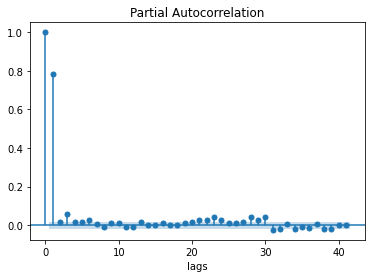

In [40]:
plot_pacf(rdf['remainder'])
plt.xlabel('lags');

###### Shadow goes till the second 'Point' -> one lag needet, but ar_lags said up to three lags are needet

###### Building a model on the lags

In [41]:
rdf.head()

,remainder,lag1,lag2,lag3
Date,,,,
1991-10-01,-10.737432,NaN,NaN,NaN
1991-10-02,-10.737635,-10.737432,NaN,NaN
1991-10-03,-10.737838,-10.737635,-10.737432,NaN
1991-10-04,-10.738041,-10.737838,-10.737635,-10.737432
1991-10-05,-10.738244,-10.738041,-10.737838,-10.737635


In [42]:
rdf.dropna(inplace=True)
rdf.head()

,remainder,lag1,lag2,lag3
Date,,,,
1991-10-04,-10.738041,-10.737838,-10.737635,-10.737432
1991-10-05,-10.738244,-10.738041,-10.737838,-10.737635
1991-10-06,-10.738447,-10.738244,-10.738041,-10.737838
1991-10-07,-10.738651,-10.738447,-10.738244,-10.738041
1991-10-08,-10.738854,-10.738651,-10.738447,-10.738244


In [43]:
Xr = rdf[['lag1','lag2','lag3']]
yr = rdf['remainder']

In [44]:
mr = LinearRegression()
mr.fit(Xr, yr)

LinearRegression()

In [45]:
rdf['predictions'] = mr.predict(Xr)

In [46]:
mr.coef_

array([ 0.76883407, -0.02764006,  0.06092315])

In [47]:
mr.score(Xr,yr)

0.6185967305823807

###### concat df=df_train and df=rdf 

In [48]:
df_train_new=df_train.loc['1991-10-04':,:]

In [49]:
rdf=rdf.drop('remainder',axis=1)

In [50]:
def concat_df_fe(df1,df2):
    
    return  pd.concat([df1,df2],axis=1)

In [51]:
df_train_done =concat_df_fe(df1=df_train_new, df2=rdf)

In [52]:
df_train_done

,TG,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,...,month_10,month_11,month_12,trend,trend_season,remainder,lag1,lag2,lag3,predictions
Date,,,,,,,,,,,,,,,,,,,,,
1991-10-04,-4.719485,1991,10,3,0,0,0,0,0,0,...,1,0,0,4.645982,6.018557,-10.738041,-10.737838,-10.737635,-10.737432,-8.611669
1991-10-05,-4.719485,1991,10,4,0,0,0,0,0,0,...,1,0,0,4.646237,6.018760,-10.738244,-10.738041,-10.737838,-10.737635,-8.611832
1991-10-06,-4.719485,1991,10,5,0,0,0,0,0,0,...,1,0,0,4.646492,6.018963,-10.738447,-10.738244,-10.738041,-10.737838,-8.611995
1991-10-07,-4.719485,1991,10,6,0,0,0,0,0,0,...,1,0,0,4.646747,6.019166,-10.738651,-10.738447,-10.738244,-10.738041,-8.612158
1991-10-08,-4.719485,1991,10,7,0,0,0,0,0,0,...,1,0,0,4.647002,6.019369,-10.738854,-10.738651,-10.738447,-10.738244,-8.612321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,6.400000,2020,11,10649,0,0,0,0,0,0,...,0,1,0,7.361776,4.054499,2.345501,1.645704,0.245907,2.246110,1.396632
2020-11-27,1.900000,2020,11,10650,0,0,0,0,0,0,...,0,1,0,7.362031,4.054702,-2.154702,2.345501,1.645704,0.245907,1.774111
2020-11-28,2.300000,2020,11,10651,0,0,0,0,0,0,...,0,1,0,7.362286,4.054905,-1.754905,-2.154702,2.345501,1.645704,-1.619861


###### Run a full model on train data

In [53]:
m_full = LinearRegression()

In [54]:
X_full = df_train_done.drop(columns=['trend','TG', 'trend_season', 'remainder','year','month','predictions'])
y_full = df_train_done['TG']

In [55]:
m_full.fit(X_full, y_full)

LinearRegression()

In [56]:
df_train_done['predict_full_model'] = m_full.predict(X_full)

In [57]:
df_train_done.tail()

,TG,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,...,month_11,month_12,trend,trend_season,remainder,lag1,lag2,lag3,predictions,predict_full_model
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-26,6.4,2020,11,10649,0,0,0,0,0,0,...,1,0,7.361776,4.054499,2.345501,1.645704,0.245907,2.246110,1.396632,5.434947
2020-11-27,1.9,2020,11,10650,0,0,0,0,0,0,...,1,0,7.362031,4.054702,-2.154702,2.345501,1.645704,0.245907,1.774111,5.811979
2020-11-28,2.3,2020,11,10651,0,0,0,0,0,0,...,1,0,7.362286,4.054905,-1.754905,-2.154702,2.345501,1.645704,-1.619861,2.419268
2020-11-29,2.0,2020,11,10652,0,0,0,0,0,0,...,1,0,7.362541,4.055109,-2.055109,-1.754905,-2.154702,2.345501,-1.145464,2.893863
2020-11-30,1.8,2020,11,10653,0,0,0,0,0,0,...,1,0,7.362796,4.055312,-2.255312,-2.055109,-1.754905,-2.154702,-1.661487,2.376740


<ipython-input-58-8878b91cd573>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_train_done.groupby('year')['TG','trend_season','predict_full_model'].mean().plot()


<AxesSubplot:xlabel='year'>

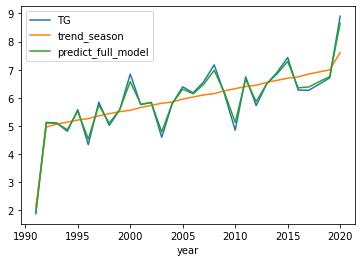

In [58]:
df_train_done.groupby('year')['TG','trend_season','predict_full_model'].mean().plot()

In [59]:
pd.DataFrame(m_full.coef_.reshape(1,15), columns=X_full.columns)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
0,0.000202,-1.004677,1.413723,5.165685,10.492039,15.238072,19.176766,18.99327,14.872797,9.655169,5.494739,2.3979,0.768698,-0.027604,0.061225


###### Evaluating the model

In [60]:
ts_split = TimeSeriesSplit(n_splits=10)

In [61]:
time_series_split = ts_split.split(X_full, y_full) 

In [62]:
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.87873297, 0.89757256, 0.90272283, 0.92466288, 0.94077812,
       0.91676436, 0.952362  , 0.94483415, 0.94229226, 0.91083471])

In [63]:
result.mean()

0.9211556838932209

Testing the model with test data

In [64]:
df_test

,TG,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Date,,,,,,,,,,,,,,,
2020-12-01,4.7,2020,12,10654,0,0,0,0,0,0,0,0,0,0,1
2020-12-02,3.2,2020,12,10655,0,0,0,0,0,0,0,0,0,0,1
2020-12-03,0.5,2020,12,10656,0,0,0,0,0,0,0,0,0,0,1
2020-12-04,2.1,2020,12,10657,0,0,0,0,0,0,0,0,0,0,1
2020-12-05,4.2,2020,12,10658,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26,-0.5,2021,11,11014,0,0,0,0,0,0,0,0,0,1,0
2021-11-27,-5.0,2021,11,11015,0,0,0,0,0,0,0,0,0,1,0
2021-11-28,-4.9,2021,11,11016,0,0,0,0,0,0,0,0,0,1,0


In [65]:
Xtest=df_test.drop(columns=['TG','year','month'])

In [66]:
ytest=df_test['TG']

In [67]:
df_test['trend_season']= m_season.predict(Xtest)

<ipython-input-67-48bb47b8b502>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['trend_season']= m_season.predict(Xtest)


In [68]:
df_test

,TG,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_season
Date,,,,,,,,,,,,,,,,
2020-12-01,4.7,2020,12,10654,0,0,0,0,0,0,0,0,0,0,1,0.922372
2020-12-02,3.2,2020,12,10655,0,0,0,0,0,0,0,0,0,0,1,0.922575
2020-12-03,0.5,2020,12,10656,0,0,0,0,0,0,0,0,0,0,1,0.922778
2020-12-04,2.1,2020,12,10657,0,0,0,0,0,0,0,0,0,0,1,0.922981
2020-12-05,4.2,2020,12,10658,0,0,0,0,0,0,0,0,0,0,1,0.923185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26,-0.5,2021,11,11014,0,0,0,0,0,0,0,0,0,1,0,4.128646
2021-11-27,-5.0,2021,11,11015,0,0,0,0,0,0,0,0,0,1,0,4.128849
2021-11-28,-4.9,2021,11,11016,0,0,0,0,0,0,0,0,0,1,0,4.129052


<ipython-input-69-c99c87fc0a64>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_test.groupby('year')['TG','trend_season'].mean().plot()


<AxesSubplot:xlabel='year'>

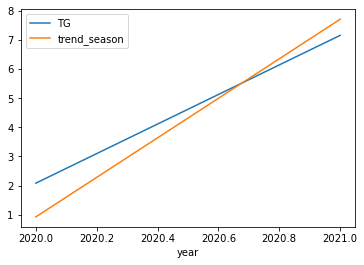

In [69]:
df_test.groupby('year')['TG','trend_season'].mean().plot()

In [70]:
df_test['remainder'] = df_test['TG'] - df_test['trend_season']

<ipython-input-70-8728d0231561>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['remainder'] = df_test['TG'] - df_test['trend_season']


###### Inserting lags

In [71]:
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)

<ipython-input-71-1ef9d961b86d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['lag1'] = df_test['remainder'].shift(1)
<ipython-input-71-1ef9d961b86d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['lag2'] = df_test['remainder'].shift(2)
<ipython-input-71-1ef9d961b86d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [72]:
df_test

,TG,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_season,remainder,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,,,,,,
2020-12-01,4.7,2020,12,10654,0,0,0,0,0,0,0,0,0,0,1,0.922372,3.777628,NaN,NaN,NaN
2020-12-02,3.2,2020,12,10655,0,0,0,0,0,0,0,0,0,0,1,0.922575,2.277425,3.777628,NaN,NaN
2020-12-03,0.5,2020,12,10656,0,0,0,0,0,0,0,0,0,0,1,0.922778,-0.422778,2.277425,3.777628,NaN
2020-12-04,2.1,2020,12,10657,0,0,0,0,0,0,0,0,0,0,1,0.922981,1.177019,-0.422778,2.277425,3.777628
2020-12-05,4.2,2020,12,10658,0,0,0,0,0,0,0,0,0,0,1,0.923185,3.276815,1.177019,-0.422778,2.277425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26,-0.5,2021,11,11014,0,0,0,0,0,0,0,0,0,1,0,4.128646,-4.628646,1.271557,-0.228239,-2.428036
2021-11-27,-5.0,2021,11,11015,0,0,0,0,0,0,0,0,0,1,0,4.128849,-9.128849,-4.628646,1.271557,-0.228239
2021-11-28,-4.9,2021,11,11016,0,0,0,0,0,0,0,0,0,1,0,4.129052,-9.029052,-9.128849,-4.628646,1.271557


In [73]:
df_train_done.tail()

,TG,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,...,month_11,month_12,trend,trend_season,remainder,lag1,lag2,lag3,predictions,predict_full_model
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-26,6.4,2020,11,10649,0,0,0,0,0,0,...,1,0,7.361776,4.054499,2.345501,1.645704,0.245907,2.246110,1.396632,5.434947
2020-11-27,1.9,2020,11,10650,0,0,0,0,0,0,...,1,0,7.362031,4.054702,-2.154702,2.345501,1.645704,0.245907,1.774111,5.811979
2020-11-28,2.3,2020,11,10651,0,0,0,0,0,0,...,1,0,7.362286,4.054905,-1.754905,-2.154702,2.345501,1.645704,-1.619861,2.419268
2020-11-29,2.0,2020,11,10652,0,0,0,0,0,0,...,1,0,7.362541,4.055109,-2.055109,-1.754905,-2.154702,2.345501,-1.145464,2.893863
2020-11-30,1.8,2020,11,10653,0,0,0,0,0,0,...,1,0,7.362796,4.055312,-2.255312,-2.055109,-1.754905,-2.154702,-1.661487,2.376740


In [74]:
df_test.loc['2020-12-01', 'lag1'] = df_train_done.loc['2020-11-30', 'remainder']
df_test.loc['2020-12-01', 'lag2'] = df_train_done.loc['2020-11-29', 'remainder']
df_test.loc['2020-12-01', 'lag3'] = df_train_done.loc['2020-11-28', 'remainder']
df_test.loc['2020-12-02', 'lag2'] = df_train_done.loc['2020-11-30', 'remainder']
df_test.loc['2020-12-02', 'lag3'] = df_train_done.loc['2020-11-29', 'remainder']
df_test.loc['2020-12-03', 'lag3'] = df_train_done.loc['2020-11-30', 'remainder']

C:\Users\bened\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [75]:
df_test

,TG,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_season,remainder,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,,,,,,
2020-12-01,4.7,2020,12,10654,0,0,0,0,0,0,0,0,0,0,1,0.922372,3.777628,-2.255312,-2.055109,-1.754905
2020-12-02,3.2,2020,12,10655,0,0,0,0,0,0,0,0,0,0,1,0.922575,2.277425,3.777628,-2.255312,-2.055109
2020-12-03,0.5,2020,12,10656,0,0,0,0,0,0,0,0,0,0,1,0.922778,-0.422778,2.277425,3.777628,-2.255312
2020-12-04,2.1,2020,12,10657,0,0,0,0,0,0,0,0,0,0,1,0.922981,1.177019,-0.422778,2.277425,3.777628
2020-12-05,4.2,2020,12,10658,0,0,0,0,0,0,0,0,0,0,1,0.923185,3.276815,1.177019,-0.422778,2.277425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26,-0.5,2021,11,11014,0,0,0,0,0,0,0,0,0,1,0,4.128646,-4.628646,1.271557,-0.228239,-2.428036
2021-11-27,-5.0,2021,11,11015,0,0,0,0,0,0,0,0,0,1,0,4.128849,-9.128849,-4.628646,1.271557,-0.228239
2021-11-28,-4.9,2021,11,11016,0,0,0,0,0,0,0,0,0,1,0,4.129052,-9.029052,-9.128849,-4.628646,1.271557


In [76]:
X_full = df_test.drop(columns=['TG','trend_season', 'remainder','year','month'])

In [77]:
df_test['predict_full_model'] = m_full.predict(X_full)

<ipython-input-77-d14f0e480ae3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict_full_model'] = m_full.predict(X_full)


<ipython-input-78-3d885bd6666b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_test.groupby('year')['TG','trend_season','predict_full_model'].mean().plot()


<AxesSubplot:xlabel='year'>

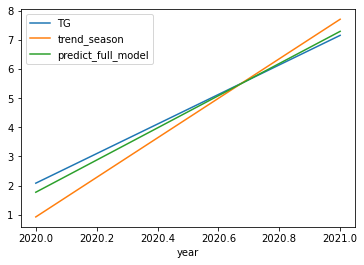

In [78]:
df_test.groupby('year')['TG','trend_season','predict_full_model'].mean().plot()

In [79]:
df_full = df_train_done[['TG', 'trend_season', 'predict_full_model']].append(df_test[['TG', 'trend_season', 'predict_full_model']])

In [80]:
df_full.head()

,TG,trend_season,predict_full_model
Date,,,
1991-10-04,-4.719485,6.018557,-2.570206
1991-10-05,-4.719485,6.018760,-2.570167
1991-10-06,-4.719485,6.018963,-2.570128
1991-10-07,-4.719485,6.019166,-2.570088
1991-10-08,-4.719485,6.019369,-2.570049


<AxesSubplot:xlabel='Date'>

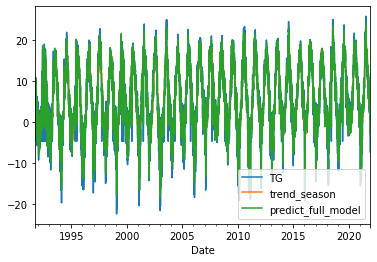

In [81]:
df_full.plot()

In [82]:
print(f"""
{m_full.score(X_full, df_test['TG'])}
{m_season.score(Xtest, df_test['TG'])}
""")



0.945834107739595
0.8135539750266674



###### Into the Future

In [83]:
df_combined=df_train_done.append(df_test)

In [84]:
df_combined

,TG,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,...,month_11,month_12,trend,trend_season,remainder,lag1,lag2,lag3,predictions,predict_full_model
Date,,,,,,,,,,,,,,,,,,,,,
1991-10-04,-4.719485,1991,10,3,0,0,0,0,0,0,...,0,0,4.645982,6.018557,-10.738041,-10.737838,-10.737635,-10.737432,-8.611669,-2.570206
1991-10-05,-4.719485,1991,10,4,0,0,0,0,0,0,...,0,0,4.646237,6.018760,-10.738244,-10.738041,-10.737838,-10.737635,-8.611832,-2.570167
1991-10-06,-4.719485,1991,10,5,0,0,0,0,0,0,...,0,0,4.646492,6.018963,-10.738447,-10.738244,-10.738041,-10.737838,-8.611995,-2.570128
1991-10-07,-4.719485,1991,10,6,0,0,0,0,0,0,...,0,0,4.646747,6.019166,-10.738651,-10.738447,-10.738244,-10.738041,-8.612158,-2.570088
1991-10-08,-4.719485,1991,10,7,0,0,0,0,0,0,...,0,0,4.647002,6.019369,-10.738854,-10.738651,-10.738447,-10.738244,-8.612321,-2.570049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26,-0.500000,2021,11,11014,0,0,0,0,0,0,...,1,0,NaN,4.128646,-4.628646,1.271557,-0.228239,-2.428036,NaN,4.948128
2021-11-27,-5.000000,2021,11,11015,0,0,0,0,0,0,...,1,0,NaN,4.128849,-9.128849,-4.628646,1.271557,-0.228239,NaN,0.506135
2021-11-28,-4.900000,2021,11,11016,0,0,0,0,0,0,...,1,0,NaN,4.129052,-9.029052,-9.128849,-4.628646,1.271557,NaN,-2.698265


In [85]:
X_combined=df_combined.drop(columns=['TG','year','month','trend','trend_season','remainder','predictions','predict_full_model'])
y_combined=df_combined['TG']

###### Creating single future step

In [86]:
timestep=df_combined['timestep'].max()+1
months=[0,0,0,0,0,0,0,0,0,0,1]
lag1=df_combined.loc['2021-11-30','remainder']
lag2=df_combined.loc['2021-11-30','lag1']
lag3=df_combined.loc['2021-11-30','lag2']

In [87]:
timestep,months,lag1,lag2,lag3

(11019,
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 -11.429458261087596,
 -7.729255119836955,
 -9.029051978586313)

In [88]:
X_future=[timestep]
X_future

[11019]

In [89]:
X_future.extend(months)
X_future

[11019, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [90]:
X_future.append(lag1)
X_future

[11019, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -11.429458261087596]

In [91]:
X_future.append(lag2)
X_future

[11019,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 -11.429458261087596,
 -7.729255119836955]

In [92]:
X_future.append(lag3)
X_future

[11019,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 -11.429458261087596,
 -7.729255119836955,
 -9.029051978586313]

In [93]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
0,11019,0,0,0,0,0,0,0,0,0,0,1,-11.429458,-7.729255,-9.029052


In [94]:
m_full.predict(X_future)

array([-8.10803371])

In [95]:
ar_model = AutoReg(endog=df_combined['remainder'], lags=3).fit()

C:\Users\bened\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\bened\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [96]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                11016
Model:                     AutoReg(3)   Log Likelihood              -24517.977
Method:               Conditional MLE   S.D. of innovations              2.242
Date:                Fri, 21 Jan 2022   AIC                              1.616
Time:                        14:29:27   BIC                              1.619
Sample:                    10-07-1991   HQIC                             1.617
                         - 11-30-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.0015      0.021     -0.072      0.942      -0.043       0.040
remainder.L1     0.7747      0.010     81.434      0.000       0.756       0.793
remainder.L2    -0.0334      0.012     -2.774      0.006      -0.057      -0.010
remainder.L3     0.0617      0.010      6.485      0.000       0.043       0.080
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2124           -0.0000j            1.2124           -0.0000
AR.2           -0.3355           -3.6415j            3.6569           -0.2646
AR.3           -0.3355           +3.6415j            3.6569            0.2646
-----------------------------------------------------------------------------
"""